# TMD - Reddit Conflict Analysis

In [2]:
import praw
import pandas as pd
import datetime as dt
from pprint import pprint
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from googleapiclient import discovery
import json
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Play around with reddit instance

In [32]:
# Please replace all variables with your own account information

reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=CLIENT_SECRET,
                     user_agent=APPLICATION_NAME,
                     username=REDDIT_USERNAME,
                     password=REDDIT_PASSWORD)

In [25]:
submission = reddit.submission(id='b2imw0')
submission.author

Redditor(name='juliassimulation')

In [46]:
for comment in reddit.redditor('odintal').comments.new(limit=10):
    print(comment.body)

Redditor(name='ValedictorianBaller')

## Observe data

In [3]:
# Please find the data at https://snap.stanford.edu/data/soc-RedditHyperlinks.html

path = '/users/sjx/desktop/'
df = pd.read_csv(path + 'soc-redditHyperlinks-title.tsv', sep='\t')
df.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."


In [4]:
print(len(df[df['LINK_SENTIMENT'] == 1].index)/df.shape[0])

0.8930982450557501


In [6]:
df.shape

(571927, 6)

In [17]:
df.iloc[16]

SOURCE_SUBREDDIT                                       subredditdrama
TARGET_SUBREDDIT                                                  nfl
POST_ID                                                        1u58yq
TIMESTAMP                                         2013-12-31 21:59:32
LINK_SENTIMENT                                                     -1
PROPERTIES          165.0,135.0,0.781818181818,0.0,0.0666666666667...
Name: 16, dtype: object

In [19]:
# BFS
post.comments.replace_more(limit=None)
for comment in post.comments.list():
    print(comment.body)

At first I typed out a comment about how butthurt Penn State fans are, but I realized that might not be very tasteful. [But we like to make jokes here, right?](http://cdn.bleacherreport.net/images_root/images/photos/001/449/442/southpark_crop_340x234.jpg?1321560453)
Where was the rape joke? 
SnapShots: [1](http://archive.is/2twN9), [2](http://hiyo.jp/cache/of/2014-01-01-15-31-24/http://www.reddit.com/r/nfl/comments/1u4y8q/bill_obrien_to_coach_houston_texans/ceejsk1), [*^Readability*](http://www.readability.com/read?url=http%3A//archive.is/2twN9)
No rape joke, not sure if disappointing or happy...


Removed: Only post links if you are not the source of the drama or directly involved in the drama.




Much Big Ten privilege. Many upset over those invalidated wins. Wow.
The jokes write themselves 
I get the feeling OP is a moron...if the "rape joke" was the lions fan saying they care
About football more than molestation then the OP totally missed the point, that wasn't a joke it was the s

In [5]:
df[df['LINK_SENTIMENT'] == -1].SOURCE_SUBREDDIT.value_counts()

subredditdrama           7550
bestof                   3464
drama                    2172
circlebroke2             1642
shitpost                 1308
shitstatistssay           928
shitredditsays            877
evenwithcontext           771
srssucks                  736
botsrights                730
shitamericanssay          717
gamingcirclejerk          611
fitnesscirclejerk         602
thebluepill               560
topmindsofreddit          495
worstof                   472
badphilosophy             458
enoughlibertarianspam     445
the_donald                430
againstkarmawhores        365
conspiracy                362
shitliberalssay           360
shitpoliticssays          345
japancirclejerk           339
againsthatesubreddits     334
metacanada                326
switcharoo                324
thepopcornstand           315
publichealthwatch         298
mensrights                285
                         ... 
waronchristmas              1
socialistsouth              1
59s       

In [6]:
df[df['LINK_SENTIMENT'] == -1].TARGET_SUBREDDIT.value_counts()

askreddit               2474
worldnews               1314
news                    1234
pics                    1111
todayilearned           1047
videos                  1028
funny                   1018
adviceanimals            828
politics                 732
wtf                      669
subredditdrama           628
the_donald               533
iama                     521
gifs                     481
gaming                   463
twoxchromosomes          455
conspiracy               435
tifu                     425
relationships            381
showerthoughts           344
movies                   330
legaladvice              314
explainlikeimfive        302
technology               299
atheism                  279
socialism                273
canada                   271
pcmasterrace             266
kotakuinaction           253
nottheonion              245
                        ... 
cityporn                   1
kindred                    1
sanders2trump              1
haruhi        

## Get all comments for conflict initiator posts
neg_comments.csv

In [4]:
neg = df[df['LINK_SENTIMENT'] == -1]
pos = df[df['LINK_SENTIMENT'] == 1]
print(neg.shape[0], pos.shape[0])

61140 510787


In [32]:
neg_not_found = 0
# pos_not_found = 0
neg_post = []
# pos_post = []

for i in range(neg.shape[0]):
    try:
        post = reddit.submission(id = neg['POST_ID'][i])
        neg_post.append(neg['POST_ID'][i])
    except:
        neg_not_found += 1
print('neg_post', len(neg_post))
print('neg_not_found', neg_not_found)

# for i in range(pos.shape[0]):
#     try:
#         post = reddit.submission(id = pos['POST_ID'][i])
#         pos_post.append(pos['POST_ID'][i])
#     except:
#         pos_not_found += 1
# print('pos_post', len(pos_post))
# print('pos_not_found', pos_not_found)

neg_post 6657
neg_not_found 54483
pos_post 456051
pos_not_found 54736


In [22]:
sia = SIA()

In [20]:
results = []
i = 300
start = time.time()

for n in range(4, len(neg_post)//100 + 2):
    
    while i >= (n-1)*100 and i < n*100:
        try:
            if i % 100 == 0:
                print(time.time() - start)
                start = time.time()
            post = reddit.submission(id = neg_post[i])
            
            
            post.comments.replace_more(limit=None)
            

            for comment in post.comments.list():
                pol_score = sia.polarity_scores(comment.body)
                pol_score['comment'] = comment.body
                try:
                    pol_score['author'] = comment.author.name
                except:
                    pol_score['author'] = None
                pol_score['submission'] = comment.submission.id
                pol_score['upvote'] = comment.score
                pol_score['is_submitter'] = comment.is_submitter
                pol_score['subreddit_id'] = comment.subreddit_id
                try:
                    pol_score['submission_author'] = post.author.name
                except:
                    pol_score['submission_author'] = None
                results.append(pol_score)
            i += 1
        except Exception as e:
            print('Handling exception at', n, i)
            print(e)
            i += 1
            time.sleep(1)
        
    print(len(results))
    comment_df = pd.DataFrame.from_records(results)
    comment_df.to_csv('comment_df_' + str(n) + '.csv')
    print('saved to file', n)

    results = []

In [22]:
all_df = []
for i in range(1, 68):
    all_df.append(pd.read_csv('comment_df_' + str(i) + '.csv', index_col=0))
df = pd.concat(all_df, ignore_index=True)
df.to_csv('neg_comments.csv')                

In [21]:
t = pd.read_csv('comment_df_1.csv', index_col=0)
t.head()

,author,comment,compound,is_submitter,neg,neu,pos,submission,submission_author,subreddit_id,upvote
0,ValedictorianBaller,At first I typed out a comment about how butth...,0.7278,False,0.000,0.810,0.190,1u58yq,sw33n3y,t5_2ss5b,7
1,odintal,Where was the rape joke?,-0.5423,False,0.475,0.303,0.222,1u58yq,sw33n3y,t5_2ss5b,6
2,ttumblrbots,"SnapShots: [1](http://archive.is/2twN9), [2](h...",0.0000,False,0.000,1.000,0.000,1u58yq,sw33n3y,t5_2ss5b,1
3,CantaloupeCamper,"No rape joke, not sure if disappointing or hap...",-0.6167,False,0.501,0.226,0.273,1u58yq,sw33n3y,t5_2ss5b,1
4,TheReasonableCamel,\n\nRemoved: Only post links if you are not th...,0.0000,False,0.000,1.000,0.000,1u58yq,sw33n3y,t5_2ss5b,1


## Get all submissions - wish to compare pos/neg post upvote, but no pos post found

In [4]:
pos_post = []
pos_not_found = 0
pos_no_title = 0
pos_id_list = pos['POST_ID'].tolist()

for i in range(pos.shape[0]):
# for i in range(50):
    try:
        post = reddit.submission(id = pos_id_list[i])
        try:
            print(post.id)
            print(post.title)
            pos_post.append(pos_id_list[i])
        except:
            pos_no_title += 1        
    except:
        pos_not_found += 1
print('pos_post', len(pos_post))
print('pos_not_found', pos_not_found)
print('pos_no_title', pos_no_title)

In [34]:
pos_sample_list = np.random.choice(pos_post, 7000)
pos_sample_list

array(['3up8its', '2x374os', '2g2g50s', ..., '54osfts', '32vzths',
       '4iafjss'], dtype='<U7')

In [5]:
results = []
start = time.time()
# all_pos_id = pos['POST_ID'].tolist()
all_id = df['POST_ID'].tolist()
cnt = 1
i = 0

# for i in range(len(pos_post)):
while cnt < 7000:
    if cnt % 100 == 0:
        print(time.time() - start)
        start = time.time()
#     print(pos_sample_list[i])
    i += 1
    post = reddit.submission(id = all_id[i])
    try:
        print(post.title)
        pol_score = sia.polarity_scores(post.title)
        pol_score['title'] = post.title
        pol_score['score'] = post.score
        pol_score['num_comments'] = post.num_comments
        results.append(pol_score)
        cnt += 1
    except Exception as e:
        print(e)
        print(i)
        time.sleep(1)
    
submission_df = pd.DataFrame.from_records(results)
submission_df.to_csv('submission_df.csv')
print('saved to file')

## Neg post comment sentiment - NLTK

In [6]:
negcdf = pd.read_csv('neg_comments.csv', index_col=0)
negcdf.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,author,comment,compound,is_submitter,neg,neu,pos,submission,submission_author,subreddit_id,upvote
idx,,,,,,,,,,,
0,ValedictorianBaller,At first I typed out a comment about how butth...,0.7278,False,0.0,0.81,0.19,1u58yq,sw33n3y,t5_2ss5b,7.0
1,odintal,Where was the rape joke?,-0.5423,False,0.475,0.303,0.222,1u58yq,sw33n3y,t5_2ss5b,6.0
2,ttumblrbots,"SnapShots: [1](http://archive.is/2twN9), [2](h...",0.0000,False,0.0,1.0,0.0,1u58yq,sw33n3y,t5_2ss5b,1.0
3,CantaloupeCamper,"No rape joke, not sure if disappointing or hap...",-0.6167,False,0.501,0.226,0.273,1u58yq,sw33n3y,t5_2ss5b,1.0
4,TheReasonableCamel,\n\nRemoved: Only post links if you are not th...,0.0000,False,0.0,1.0,0.0,1u58yq,sw33n3y,t5_2ss5b,1.0


In [7]:
negcdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135667 entries, 0 to 135666
Data columns (total 11 columns):
author               103363 non-null object
comment              135662 non-null object
compound             135647 non-null float64
is_submitter         135647 non-null object
neg                  135647 non-null object
neu                  135646 non-null object
pos                  135644 non-null object
submission           135647 non-null object
submission_author    116562 non-null object
subreddit_id         135630 non-null object
upvote               135630 non-null float64
dtypes: float64(2), object(9)
memory usage: 12.4+ MB


In [8]:
# remove malformatted rows

negcdf.drop(negcdf[negcdf.upvote.isnull()].index, inplace=True)
negcdf.shape

(135630, 11)

In [9]:
negcdf.neg = negcdf.neg.astype(float)
negcdf.neu = negcdf.neu.astype(float)
negcdf.pos = negcdf.pos.astype(float)

In [114]:
a = len(negcdf[negcdf['compound'] < -0.5].index)/negcdf.shape[0]
b = len(negcdf[negcdf['compound'] > 0.5].index)/negcdf.shape[0]
c = len(negcdf[(negcdf['compound'] >= -0.5) & (negcdf['compound'] <= 0.5)].index)/negcdf.shape[0]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  


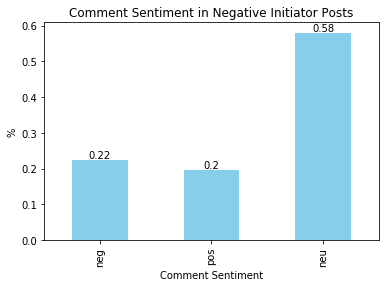

In [115]:
frequencies = [a, b, c]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['neg', 'pos', 'neu']

plt.figure()
ax = freq_series.plot(kind='bar', color='skyblue')
ax.set_title('Comment Sentiment in Negative Initiator Posts')
ax.set_xlabel('Comment Sentiment')
ax.set_ylabel('%')
ax.set_xticklabels(x_labels)

rects = ax.patches

labels = [round(frequencies[i],2) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')

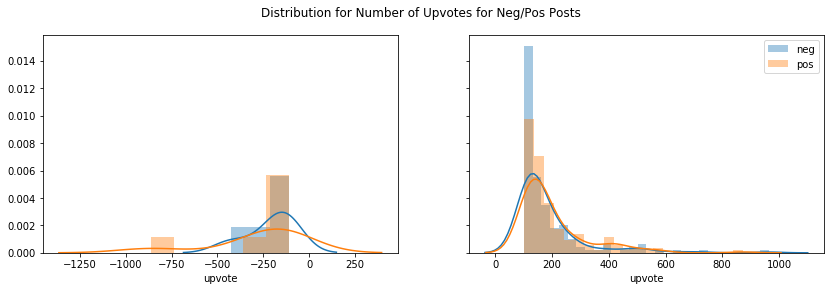

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharey=True)
ax1 = sns.distplot(negcdf.loc[(negcdf['compound'] < -0.5) & (negcdf['upvote'] < -100), 'upvote'], ax=ax1, label='neg')
ax1 = sns.distplot(negcdf.loc[(negcdf['compound'] > 0.5) & (negcdf['upvote'] < -100), 'upvote'], ax=ax1, label='pos')
ax2 = sns.distplot(negcdf.loc[(negcdf['compound'] < -0.5) & (negcdf['upvote'] > 100), 'upvote'], ax=ax2, label='neg')
ax2 = sns.distplot(negcdf.loc[(negcdf['compound'] > 0.5) & (negcdf['upvote'] > 100), 'upvote'], ax=ax2, label='pos')
plt.suptitle('Distribution for Number of Upvotes for Neg/Pos Posts')
plt.legend()

## Neg post comment sentiment - Perspective API

In [112]:
ct = pd.read_csv('neg_comment_toxicity.csv', index_col=0)
ct.head()

,flirtation,identity_attack,idx,insult,profanity,sexually_explicit,text,threat,toxicity
0,0.519920,0.211680,0,0.264306,0.316808,0.412435,At first I typed out a comment about how butth...,0.280437,0.252440
1,0.403854,0.140421,1,0.236061,0.397672,0.799199,Where was the rape joke?,0.373892,0.501629
2,0.263957,0.046450,2,0.033025,0.044540,0.088662,"SnapShots: [1](http://archive.is/2twN9), [2](h...",0.144010,0.054881
3,0.497973,0.134218,3,0.248090,0.438623,0.838079,"No rape joke, not sure if disappointing or hap...",0.408097,0.506458
4,0.099253,0.057346,18959,0.042744,0.020241,0.033699,\n\nRemoved: Only post links if you are not th...,0.151483,0.064819


In [88]:
merged = pd.merge(negcdf, ct, left_index=True, right_on='idx')
merged.drop('idx', axis=1, inplace=True)
merged.head()

,author,comment,compound,is_submitter,neg,neu,pos,submission,submission_author,subreddit_id,upvote,flirtation,identity_attack,insult,profanity,sexually_explicit,text,threat,toxicity
0,ValedictorianBaller,At first I typed out a comment about how butth...,0.7278,False,0.000,0.810,0.190,1u58yq,sw33n3y,t5_2ss5b,7.0,0.519920,0.211680,0.264306,0.316808,0.412435,At first I typed out a comment about how butth...,0.280437,0.252440
1,odintal,Where was the rape joke?,-0.5423,False,0.475,0.303,0.222,1u58yq,sw33n3y,t5_2ss5b,6.0,0.403854,0.140421,0.236061,0.397672,0.799199,Where was the rape joke?,0.373892,0.501629
2,ttumblrbots,"SnapShots: [1](http://archive.is/2twN9), [2](h...",0.0000,False,0.000,1.000,0.000,1u58yq,sw33n3y,t5_2ss5b,1.0,0.263957,0.046450,0.033025,0.044540,0.088662,"SnapShots: [1](http://archive.is/2twN9), [2](h...",0.144010,0.054881
3,CantaloupeCamper,"No rape joke, not sure if disappointing or hap...",-0.6167,False,0.501,0.226,0.273,1u58yq,sw33n3y,t5_2ss5b,1.0,0.497973,0.134218,0.248090,0.438623,0.838079,"No rape joke, not sure if disappointing or hap...",0.408097,0.506458
5,NaN,Much Big Ten privilege. Many upset over those ...,0.8126,False,0.133,0.357,0.510,1u58yq,sw33n3y,t5_2ss5b,-2.0,0.293974,0.128447,0.090597,0.055063,0.093252,Much Big Ten privilege. Many upset over those ...,0.124298,0.104260


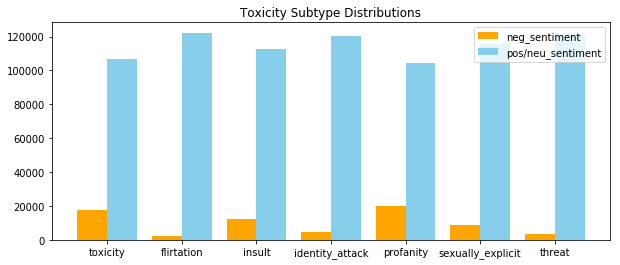

In [96]:
x = np.arange(7)
y = [len(merged[merged['toxicity'] > 0.7].index), len(merged[merged['flirtation'] > 0.7].index), len(merged[merged['insult'] > 0.7].index), 
    len(merged[merged['identity_attack'] > 0.7].index), len(merged[merged['profanity'] > 0.7].index), len(merged[merged['sexually_explicit'] > 0.7].index), len(merged[merged['threat'] > 0.7].index)]
z = [len(merged[merged['toxicity'] < 0.7].index), len(merged[merged['flirtation'] < 0.7].index), len(merged[merged['insult'] < 0.7].index), 
    len(merged[merged['identity_attack'] < 0.7].index), len(merged[merged['profanity'] < 0.7].index), len(merged[merged['sexually_explicit'] < 0.7].index), len(merged[merged['threat'] < 0.7].index)]

fig= plt.figure(figsize=(10,4))
ax = plt.subplot(111)
ax.bar(x-0.2, y, width=0.4, color='orange', align='center', label='neg_sentiment')
ax.bar(x+0.2, z, width=0.4, color='skyblue', align='center', label='pos/neu_sentiment')

col_list = ['', 'toxicity', 'flirtation', 'insult', 'identity_attack', 'profanity', 'sexually_explicit', 'threat']
ax.set_xticklabels(col_list)
ax.set_title('Toxicity Subtype Distributions')
plt.legend()

## Get author information for neg post comments
neg_comment_authors.csv

In [17]:
tmp = negcdf.loc[negcdf['compound'] < -0.5, ['author', 'subreddit_id']].drop_duplicates().dropna().sort_values(by=['author'])
tmp

,author,subreddit_id
idx,,
53277,--hundy,t5_2qh3v
99723,--mt__,t5_2qh4r
103484,-Mass,t5_2qh3v
59515,-PaperbackWriter-,t5_2qh3v
117316,-Pin_Cushion-,t5_2tzlb
19558,-__--,t5_2rybl
78253,-katbyte,t5_2s4m9
27467,-momoyome-,t5_2qh3v
38853,-xyz,t5_2vzvv


In [71]:
list(reddit.info(['t5_2qh3v']))

[Subreddit(display_name='bestof')]

In [18]:
tmpcnt = tmp.author.value_counts().to_frame()
tmpcnt.columns = ['count']
tmpcnt[:100]

,count
autowikibot,21
totes_meta_bot,20
shitpostwhisperer,9
cordis_melum,8
deathpigeonx,8
EvanHarper,7
blarghable,7
5th_Law_of_Robotics,7
Slutlord-Fascist,7
SweetNyan,6


In [97]:
nca = tmpcnt[tmpcnt['count'] > 2].index.tolist()
len(nca)

232

In [103]:
authors = []
is_mod = []
register_utc = []
new_utc = []
comment_karma = []
avg_comment_score = []
avg_comment_sentiment = []

for a in nca:
    score = 0
    sentiment = 0
    
    print('\n--------------------------', a, '--------------------------')
    author = reddit.redditor(a)
    
    try:       
        # as a proxy of activeness???
        new_utc.append(list(author.comments.new(limit=1))[0].created_utc)
        register_utc.append(author.created_utc)
        comment_karma.append(author.comment_karma)
        is_mod.append(author.is_mod)
        authors.append(a)

        for comment in author.comments.new(limit=100):
            score += comment.score
            sentiment += sia.polarity_scores(comment.body)['compound']
        avg_comment_score.append(score/100)
        avg_comment_sentiment.append(sentiment/100)
               
        print(authors[-1], register_utc[-1], new_utc[-1], comment_karma[-1], is_mod[-1], avg_comment_score[-1], avg_comment_sentiment[-1])
    except Exception as e:
        print(e)



-------------------------- autowikibot --------------------------
autowikibot 1388865420.0 1436925377.0 519913 True 1.7 0.21285499999999996

-------------------------- totes_meta_bot --------------------------
totes_meta_bot 1391496985.0 1425296211.0 222827 True 3.84 0.033076999999999995

-------------------------- shitpostwhisperer --------------------------
shitpostwhisperer 1387325335.0 1431705952.0 33416 False 1.7 -0.07047999999999999

-------------------------- cordis_melum --------------------------
cordis_melum 1388615307.0 1553218058.0 124292 True 4.95 0.680307

-------------------------- deathpigeonx --------------------------
deathpigeonx 1371328403.0 1534990443.0 63968 True 4.98 0.07021799999999999

-------------------------- EvanHarper --------------------------
EvanHarper 1359420745.0 1553200553.0 154707 True 0.06 -0.0021469999999999966

-------------------------- blarghable --------------------------
blarghable 1381398539.0 1553214374.0 73581 False 10.79 0.09061499999999

BullsLawDan 1338483550.0 1553214566.0 157117 True 5.83 -0.03860200000000001

-------------------------- Sir_Marcus --------------------------
Sir_Marcus 1332952736.0 1480726431.0 79700 False 22.59 -0.06926299999999999

-------------------------- piyochama --------------------------
piyochama 1299459852.0 1543472402.0 77322 True 9.41 0.14689400000000002

-------------------------- DonQuixoteReference --------------------------
DonQuixoteReference 1368401779.0 1553114559.0 51668 True 6.54 0.06646700000000001

-------------------------- Herkimer --------------------------
Herkimer 1228179016.0 1410122154.0 28632 True 6.24 -0.18743499999999996

-------------------------- ShillForMonsanto --------------------------
ShillForMonsanto 1381664797.0 1439126714.0 481 False 1.25 -0.06477299999999998

-------------------------- DualPollux --------------------------
received 404 HTTP response

-------------------------- InOranAsElsewhere --------------------------
InOranAsElsewhere 1363733880.0 1553

list index out of range

-------------------------- veryhairyberry --------------------------
received 404 HTTP response

-------------------------- RoflCopter4 --------------------------
RoflCopter4 1316710419.0 1499344948.0 60725 False 2.68 0.05171799999999999

-------------------------- nicethingyoucanthave --------------------------
nicethingyoucanthave 1355522757.0 1553215025.0 78140 True 11.0 -0.07388900000000001

-------------------------- dancesontrains --------------------------
list index out of range

-------------------------- Townsley --------------------------
received 404 HTTP response

-------------------------- BustaHymes --------------------------
BustaHymes 1328036725.0 1552494569.0 5341 True 0.79 0.088034

-------------------------- Txmedic --------------------------
Txmedic 1326415419.0 1477258197.0 23037 True 2.29 0.095904

-------------------------- numb3rb0y --------------------------
numb3rb0y 1186517892.0 1552553725.0 51584 True 11.61 0.22668799999999997

----

shitsfuckedupalot 1320945081.0 1553135969.0 136449 False 5.52 0.005322

-------------------------- illuminutcase --------------------------
illuminutcase 1352503586.0 1553209821.0 172021 True 30.88 0.007640000000000003

-------------------------- greenduch --------------------------
greenduch 1286731280.0 1540865579.0 68302 True 4.49 0.24654000000000006

-------------------------- Zorkamork --------------------------
Zorkamork 1345180649.0 1552763051.0 103402 False 10.76 -0.018844000000000003

-------------------------- sp8der --------------------------
sp8der 1330742283.0 1553206928.0 121845 True 3.36 -0.08842599999999991

-------------------------- DongQuixote1 --------------------------
DongQuixote1 1359509717.0 1553207707.0 64447 True 12.08 -0.05180999999999997

-------------------------- autourbanbot --------------------------
autourbanbot 1390342244.0 1508963972.0 98479 True 5.0 -0.12168200000000001

-------------------------- ReLiC71 --------------------------
ReLiC71 1282859231

In [104]:
print(len(authors), len(register_utc), len(new_utc), len(comment_karma), len(is_mod), len(avg_comment_score), len(avg_comment_sentiment))

196 196 196 196 196 196 196


In [105]:
ncadf = pd.DataFrame(data={'author':authors, 'register_utc':register_utc, 'new_utc':new_utc, 'comment_karma':comment_karma, 'is_mod':is_mod, 'avg_comment_score':avg_comment_score, 'avg_comment_sentiment':avg_comment_sentiment})
ncadf.to_csv('neg_comment_authors.csv')
ncadf

,author,register_utc,new_utc,comment_karma,is_mod,avg_comment_score,avg_comment_sentiment
0,autowikibot,1.388865e+09,1.436925e+09,519913,True,1.70,0.212855
1,totes_meta_bot,1.391497e+09,1.425296e+09,222827,True,3.84,0.033077
2,shitpostwhisperer,1.387325e+09,1.431706e+09,33416,False,1.70,-0.070480
3,cordis_melum,1.388615e+09,1.553218e+09,124292,True,4.95,0.680307
4,deathpigeonx,1.371328e+09,1.534990e+09,63968,True,4.98,0.070218
5,EvanHarper,1.359421e+09,1.553201e+09,154707,True,0.06,-0.002147
6,blarghable,1.381399e+09,1.553214e+09,73581,False,10.79,0.090615
7,5th_Law_of_Robotics,1.354234e+09,1.553203e+09,514971,True,5.99,-0.050769
8,SweetNyan,1.382408e+09,1.552658e+09,44326,True,11.23,0.061958
9,_watching,1.372707e+09,1.508948e+09,169857,True,5.87,0.078976


In [106]:
ncadf['new_utc'] = pd.to_datetime(ncadf['new_utc'], unit='s').dt.date
ncadf['register_utc'] = pd.to_datetime(ncadf['register_utc'], unit='s').dt.date
ncadf['age'] = ncadf['new_utc'] - ncadf['register_utc']
ncadf.head()

,author,register_utc,new_utc,comment_karma,is_mod,avg_comment_score,avg_comment_sentiment,age
0,autowikibot,2014-01-04,2015-07-15,519913,True,1.70,0.212855,557 days
1,totes_meta_bot,2014-02-04,2015-03-02,222827,True,3.84,0.033077,391 days
2,shitpostwhisperer,2013-12-18,2015-05-15,33416,False,1.70,-0.070480,513 days
3,cordis_melum,2014-01-01,2019-03-22,124292,True,4.95,0.680307,1906 days
4,deathpigeonx,2013-06-15,2018-08-23,63968,True,4.98,0.070218,1895 days


Text(0.5,1,'Average Comment Sentiment by Comment Author')

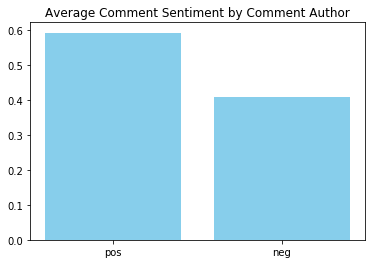

In [107]:
x = np.arange(2)
a = len(ncadf[ncadf['avg_comment_sentiment'] > 0].index)/ncadf.shape[0]
b = len(ncadf[ncadf['avg_comment_sentiment'] < 0].index)/ncadf.shape[0]
values = [a, b]
p, n = plt.bar(x, values)
p.set_facecolor('skyblue')
n.set_facecolor('skyblue')
plt.xticks(x, ('pos', 'neg'))
plt.title('Average Comment Sentiment by Comment Author')

Text(0.5,1,'Moderator Distribution among Comment Authos')

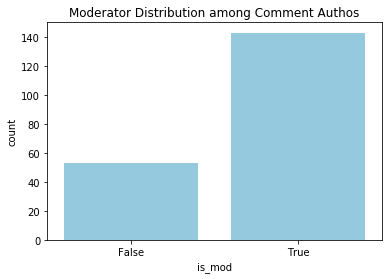

In [108]:
sns.countplot(x='is_mod', data=ncadf, color='skyblue')
plt.title('Moderator Distribution among Comment Authos')

In [109]:
ncadf['age_f'] = ncadf['age'].map(lambda x:x.days)

Text(0.5,1,'Activeness Distribution of Comment Authors')

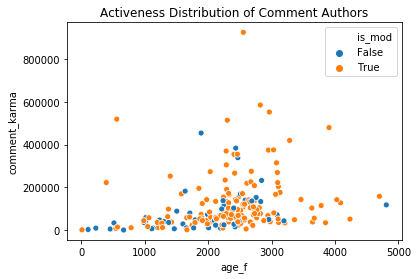

In [110]:
sns.scatterplot(x='age_f', y='comment_karma', hue='is_mod', data=ncadf)
plt.title('Activeness Distribution of Comment Authors')

## --- Perspective ---
neg_comment_toxicity.csv

In [ ]:
from googleapiclient import discovery
from googleapiclient.errors import HttpError

In [ ]:
# from perspective import Perspective
# p = Perspective(API_KEY)

comments = pd.read_csv('neg_comments.csv', index_col=0)
print('before dropping:', comments.shape)
to_drop = comments[comments.upvote.isnull()].index
print('to_drop:', to_drop)
comments.drop(to_drop, inplace=True)
# comments.drop(comments['comment'].str.contains('http').index, inplace=True)
# comments.drop(comments['comment'].str.contains('[]').index, inplace=True)
print('after dropping:', comments.shape)

In [ ]:
text = comments['comment'].tolist()
print(len(text))

# text:idx
rc = {}
for k, v in comments['comment'].to_dict().items():
    rc[v] = k

In [ ]:
# Please replace API_KEY with your own Google API Client key

service = discovery.build('commentanalyzer', 'v1alpha1', developerKey=API_KEY)

comment_toxicity = []

start = time.time()
cnt = 0
rclist = list(rc.items())[19059:]
while cnt < len(rclist):
# for t, v in list(rc.items())[29180:]:
#     cnt += 1
    if cnt % 1000 == 0:
        print(time.time() - start)
        start = time.time()

    t, v = rclist[cnt]
#     print(v, t)
    comment = {}
    comment['idx'] = v
    comment['text'] = t
    
    analyze_request = {
      'comment': {'text': t},
      'requestedAttributes': {'TOXICITY': {}, 'IDENTITY_ATTACK':{}, 'INSULT':{}, 'PROFANITY':{}, 'THREAT':{}, 'SEXUALLY_EXPLICIT':{}, 'FLIRTATION':{}}
    }
    
    try:
        response = service.comments().analyze(body=analyze_request).execute()
        # print(json.dumps(response, indent=2))

        comment['toxicity'] = response['attributeScores']['TOXICITY']['summaryScore']['value']
        comment['identity_attack'] = response['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value']
        comment['insult'] = response['attributeScores']['INSULT']['summaryScore']['value']
        comment['profanity'] = response['attributeScores']['PROFANITY']['summaryScore']['value']
        comment['threat'] = response['attributeScores']['THREAT']['summaryScore']['value']
        comment['sexually_explicit'] = response['attributeScores']['SEXUALLY_EXPLICIT']['summaryScore']['value']
        comment['flirtation'] = response['attributeScores']['FLIRTATION']['summaryScore']['value']

        comment_toxicity.append(comment)
        cnt += 1
        
    except HttpError as e:
        print('\n----------------------------------------------------')
        # all scores should be nan
        if e.resp.status == 429:
            print(v)
            print('Sleeping...')
            time.sleep(1)
        if e.resp.status == 400:
            print(e)
            print(t)
            cnt += 1

In [ ]:
comment_toxicity[1000]

comment_toxicity_df = pd.DataFrame(comment_toxicity)
comment_toxicity_df.shape
comment_toxicity_df.to_csv('neg_comment_toxicity_2.csv')

In [ ]:
ctdf = pd.read_csv('neg_comment_toxicity_1.csv')
ctdf.drop('Unnamed: 0', axis=1, inplace=True)

all_ctdf = pd.concat([ctdf, comment_toxicity_df], ignore_index=True)
all_ctdf.to_csv('neg_comment_toxicity.csv')